# 118B Final Project: Target Risk-Genes of ASD
Yufei Deng, Mengyu Zhang

## Dataset:
- Source: Gene Expression Omnibus (GEO) 

    - Alter MD, Kharkar R, Ramsey KE, Craig DW et al. Autism and increased paternal age related changes in global levels of gene expression regulation. PLoS One 2011 Feb 17;6(2):e16715. PMID: 21379579
- Link to data: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25507/matrix/
- Feature: 
    - 146 observations : Consists of samples of gene expression collected from children; divided into binary groups: the "autism" gruoup (n=82) and the "control" group (n=66)
    - and 54614 features : A "group" feature which indicates group membership; 54613 genes 

## Objectives
Using Feature Selection techniques and classification algorithms to pinpoint a set of risk genes of ASD in children

## Data Analysis

In [1]:
# !pip install umap-learn

In [728]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'
import seaborn as sns
import umap

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import linear_model as lm

from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import (accuracy_score, auc, roc_curve)

In [824]:
gene = pd.read_csv('Data/ASD gene expression.csv', header=None).transpose()

In [825]:
# reset var headers
gene.columns = gene.iloc[0,:]
gene = gene.iloc[1:,:-1]
gene = gene.drop(columns=['age', 'paternal age','maternal age'])

# clean 'group' column
gene['group'] = gene['group'].apply(lambda x: x[x.index(':')+2 : ])

# NA & convert data type
gene = gene.replace('n/a',np.NaN)
gene.iloc[:, 1:] = gene.iloc[:, 1:].astype('float')
gene.head()

,group,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
1,control,179.823156,118.483553,1185.853438,133.932196,7.221823,992.334017,32.641761,18.757609,1783.295415,...,2012.914251,5.766560,168.708985,44.688942,118.658283,692.439877,19.148215,43.415070,89.785776,290.520065
2,control,159.980250,135.384522,827.135570,161.661239,9.382673,785.185108,34.585418,19.587671,1414.856479,...,2083.942852,6.345531,171.337722,45.876550,112.323813,640.713687,18.761184,37.780084,86.112932,192.904234
3,control,159.900207,133.069673,894.275164,140.230951,7.441044,882.209814,35.264923,22.181254,1644.074546,...,1724.951400,6.280289,140.696244,47.422342,133.583962,603.754824,17.250449,40.061929,91.372429,245.499963
4,control,113.358519,133.848207,1717.030558,181.777396,8.197256,803.757787,42.306223,18.238485,1095.466765,...,2152.354502,7.240142,128.135996,53.703083,139.727483,1305.765397,11.179734,50.690237,112.260533,321.308871
5,control,145.801020,96.860396,798.728842,173.557392,7.612530,1078.843587,44.220088,20.908273,4414.211376,...,2098.306918,6.727498,202.271325,47.783181,115.388129,721.284694,16.917635,55.017817,108.857047,169.840534


In [506]:
# log2 transformation
# gene.iloc[:,4:] = np.log2(gene.iloc[:,3:] +1)
# # fill NAs with column mean
# gene = gene.fillna(gene.groupby(by='group').transform('mean'))

## Visualizing High-Dim Data with UMAP

In [821]:
def draw_umap(data, RS = 49457134):
    embedding = umap.UMAP(random_state=RS).fit_transform(data)
   
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
                hue=gene.group, 
                hue_order=['autism','control'],
                palette='hls', s=150)

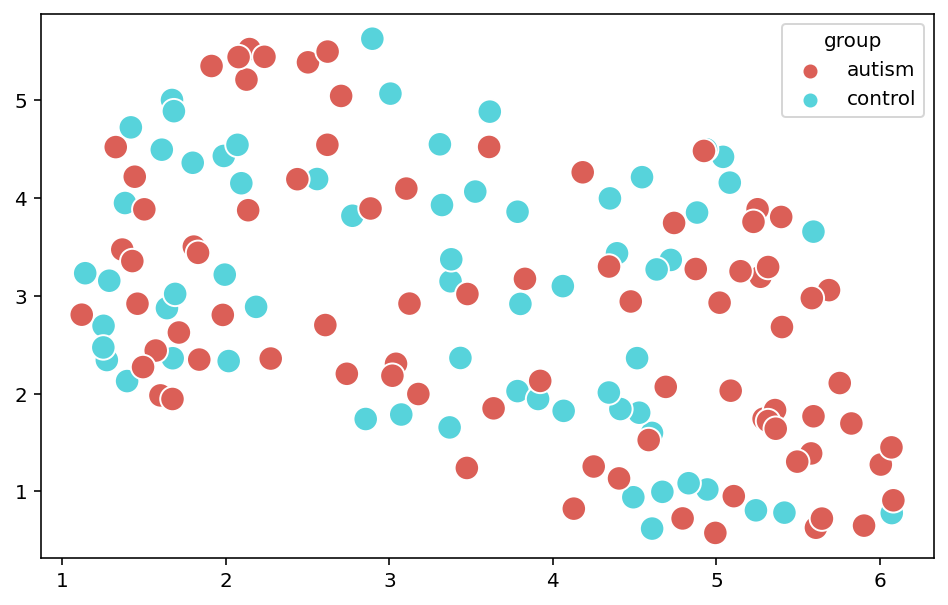

In [508]:
raw_data = gene.iloc[:,1:]
draw_umap(raw_data)

## Preprocessing Data with Between-Group Mean Difference

In [731]:
# Median expression by group
median = gene.groupby(by=['group']).median()

# Create table of expression mean&median
expression = gene.groupby(by=['group']).mean()
x1 = expression.iloc[0,].values
x2 = expression.iloc[1,].values
expression.loc['mean ratio'] = (x1/x2)
expression.loc['autism median'] = median.iloc[0]
expression.loc['control median'] = median.iloc[1]
expression.loc['median ratio'] = (median.iloc[0] / median.iloc[1])
expression

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
group,,,,,,,,,,,,,,,,,,,,,
autism,145.239406,139.101613,1150.717162,151.235071,7.983926,895.311271,38.520847,19.156823,1949.657397,11.534674,...,2054.159106,6.493249,159.354107,49.164529,153.982469,787.973735,19.203685,44.151465,95.529049,275.244657
control,137.585009,142.981458,1267.093233,141.971725,7.859441,878.641795,35.986692,19.126680,1944.452538,11.595492,...,2114.018252,6.447156,157.760102,43.994307,155.820650,849.529392,21.220376,43.427111,90.635512,286.303158
mean ratio,1.055634,0.972865,0.908155,1.065248,1.015839,1.018972,1.070419,1.001576,1.002677,0.994755,...,0.971685,1.007149,1.010104,1.117520,0.988203,0.927541,0.904964,1.016680,1.053991,0.961375
autism median,141.841928,139.635943,1031.983589,150.735616,7.875875,848.464188,37.782935,19.002005,1756.376814,11.470204,...,2062.783528,6.466256,146.038257,47.936812,150.295510,737.164255,18.161098,42.920768,93.178178,261.897964
control median,136.778769,143.207814,1174.405681,140.174063,7.807232,862.640590,35.202202,18.898798,1768.706655,11.776884,...,2099.820622,6.320571,153.046486,42.787136,151.933283,783.260151,21.217363,42.474993,88.976787,273.794963
median ratio,1.037017,0.975058,0.878728,1.075346,1.008792,0.983566,1.073312,1.005461,0.993029,0.973959,...,0.982362,1.023049,0.954208,1.120356,0.989220,0.941149,0.855955,1.010495,1.047219,0.956548


In [733]:
# expression variance
variance_df = pd.DataFrame(gene.iloc[:,1:].apply(np.var,axis=0),
                          columns=['variance']).sort_values(by='variance', ascending=False)
high_var = variance_df[:(int(len(variance_df)*0.15))].index.tolist()

In [772]:
def filter_by_MeanOrMedian(r = 0.9): # ratio of group means
    #by mean
    by_mean = expression.drop(columns=high_var)
    exp_df = pd.DataFrame((by_mean.iloc[2] > r**(-1))|(by_mean.iloc[2] < r))
    ind_mean = exp_df[exp_df['mean ratio']==True].index.to_list()
    # high variance by median
    by_median = expression.loc[:,high_var]
    exp_df = pd.DataFrame((by_median.iloc[5] > r**(-1))|(by_median.iloc[5] < r))
    ind_median = exp_df[exp_df['median ratio']==True].index.to_list()
    ind = [gene.columns[0]] + ind_mean + ind_median
    
    gene_flt_mean = gene.loc[:,ind]
    return gene_flt_mean


def plot_filter(figsize, r=0.9):
    m_ratio = x1/x2
    median_ratio = expression.iloc[5].values
    
    plt.figure(figsize=figsize)    
    plt.plot(m_ratio, label='mean', alpha=0.6)
    plt.plot(median_ratio, label='median',alpha=0.7)
    
    plt.axhline(y=r, linestyle='--', linewidth=2)
    plt.axhline(y=r**(-1),linestyle='--',linewidth=2)
    plt.legend()


In [773]:
gene_flt = filter_by_MeanOrMedian(r=0.9)
gene_flt.shape

(146, 2708)

Text(25000, 1, 'filtered out')

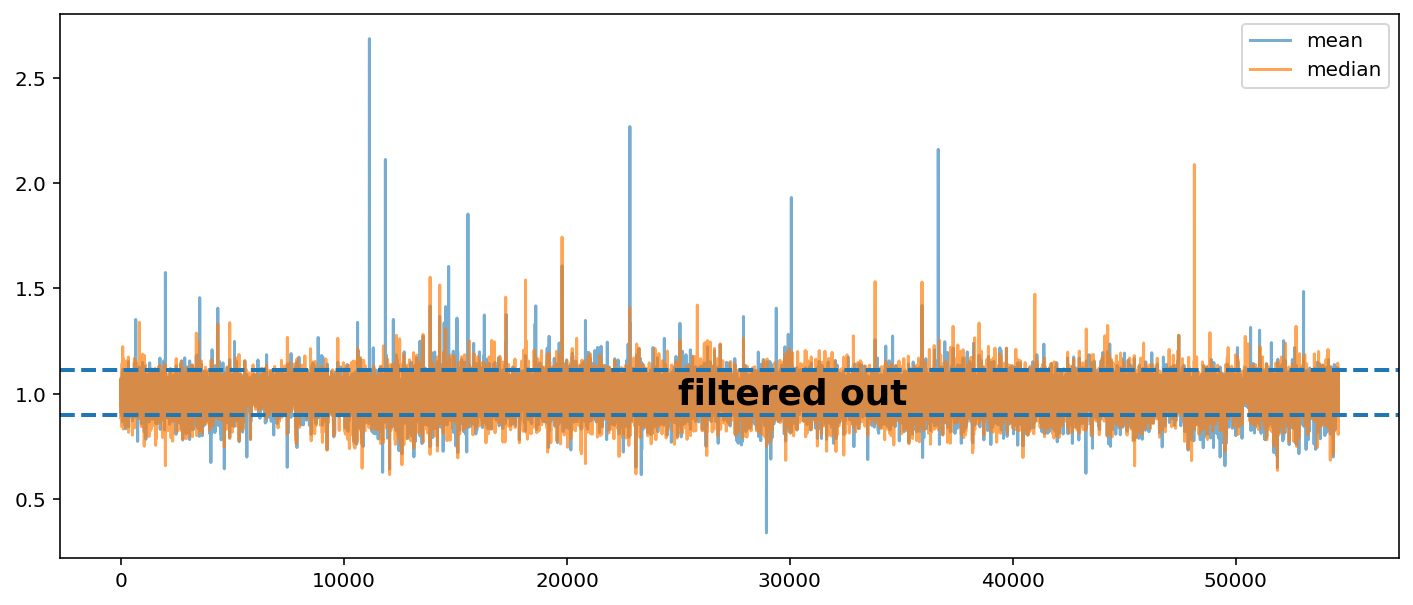

In [774]:
plot_filter(figsize=(12,5))
plt.text(25000, 1, 'filtered out', verticalalignment='center',
         fontsize=18,weight='bold')

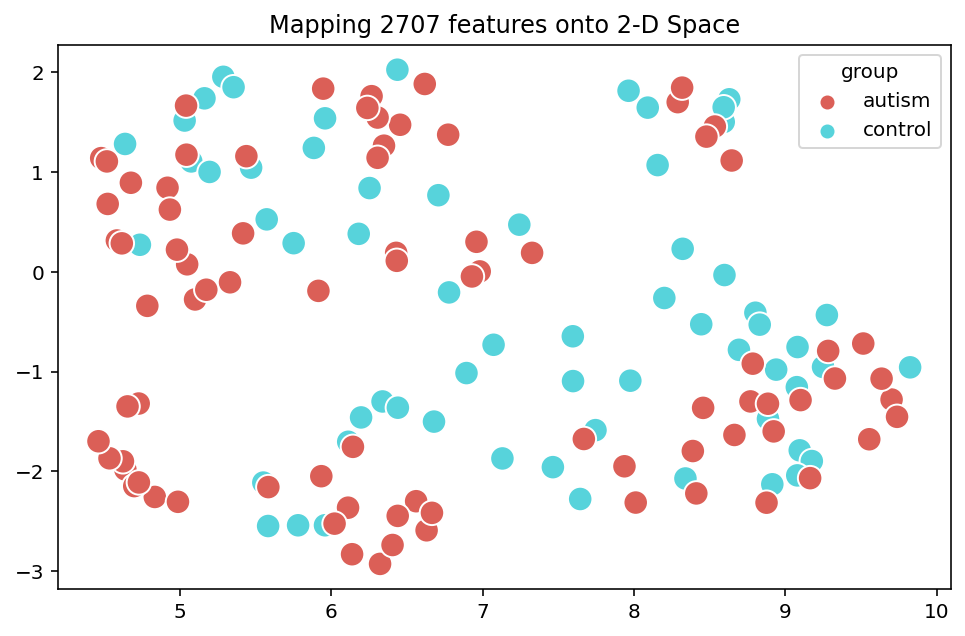

In [775]:
draw_umap(gene_flt.iloc[:,1:])
plt.title('Mapping 2707 features onto 2-D Space')
plt.show()

In [303]:
# gene_flt.to_csv('Data/gene_preprocessed_2707.csv')

In [96]:
### Filter by Variance
# plt.figure(figsize=(15,5))
# plt.plot(variance_df[:100])
# plt.xticks(np.arange(100), labels=[f'{i}' for i in range(1,101)],
#           rotation=60)
# plt.show()

In [ ]:
# var_table = variance_df['variance'].describe()
# threshold = var_table[1] + 2*var_table[2]

# ind = variance_df[variance_df['variance'] > threshold].index
# ind = list(gene.columns[1:4]) + list(ind)

# gene_flt_var = gene.loc[:, ind]
# flt_data = gene_flt_var.iloc[:,1:]
# draw_umap(flt_data)

## Selection by Correlation of Feature

__Feature discriminability__: $$S(f) = \frac{\sum^K{P^2_{k}(C_k - c)^2}} {\sigma^2(f)\sum^K{P_{k}(1- P_{k})}}$$ 
- $P(k)$ is the probability of the appearance of the $k^{th}$ class in the dataset
- K is the number of classes; $K=2$
- $\sigma^2(f)$ is the variance of the feature $=Var(f)$

In [776]:
expression.loc['mean expression'] = expression.iloc[:2,:].mean(axis=0)
expression

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
group,,,,,,,,,,,,,,,,,,,,,
autism,145.239406,139.101613,1150.717162,151.235071,7.983926,895.311271,38.520847,19.156823,1949.657397,11.534674,...,2054.159106,6.493249,159.354107,49.164529,153.982469,787.973735,19.203685,44.151465,95.529049,275.244657
control,137.585009,142.981458,1267.093233,141.971725,7.859441,878.641795,35.986692,19.126680,1944.452538,11.595492,...,2114.018252,6.447156,157.760102,43.994307,155.820650,849.529392,21.220376,43.427111,90.635512,286.303158
mean ratio,1.055634,0.972865,0.908155,1.065248,1.015839,1.018972,1.070419,1.001576,1.002677,0.994755,...,0.971685,1.007149,1.010104,1.117520,0.988203,0.927541,0.904964,1.016680,1.053991,0.961375
autism median,141.841928,139.635943,1031.983589,150.735616,7.875875,848.464188,37.782935,19.002005,1756.376814,11.470204,...,2062.783528,6.466256,146.038257,47.936812,150.295510,737.164255,18.161098,42.920768,93.178178,261.897964
control median,136.778769,143.207814,1174.405681,140.174063,7.807232,862.640590,35.202202,18.898798,1768.706655,11.776884,...,2099.820622,6.320571,153.046486,42.787136,151.933283,783.260151,21.217363,42.474993,88.976787,273.794963
median ratio,1.037017,0.975058,0.878728,1.075346,1.008792,0.983566,1.073312,1.005461,0.993029,0.973959,...,0.982362,1.023049,0.954208,1.120356,0.989220,0.941149,0.855955,1.010495,1.047219,0.956548
mean expression,141.412208,141.041536,1208.905197,146.603398,7.921684,886.976533,37.253770,19.141752,1947.054967,11.565083,...,2084.088679,6.470202,158.557105,46.579418,154.901559,818.751563,20.212030,43.789288,93.082281,280.773908


In [784]:
def feature_discimination(Pk, # probability of the appearance of the  𝑘𝑡ℎ class
                        ck, # mean expression by class
                        c,  # mean expression of both classes
                        var,# feature variance
                        k=2): # number of classes (=2)
    upper = sum( [Pk[i]**2 * (ck[i]-c)**2 for i in range(k)] )
    lower = sum( [Pk[i] * (1-Pk[i]) for i in range(k)] )
    D = upper / (var[0]*lower)
    return D


def calc_COR(data=gene_flt.iloc[:,1:]): #default is 2707-f dataset
    Pk = [gene['group'].value_counts()[0] / len(gene),
          gene['group'].value_counts()[1] / len(gene)]
    
    Sf = []
    # loop through all gene features
    for f in data.columns: 
        var = variance_df.loc[f].tolist()
        ck = expression[f][:2].tolist()
        c = expression[f][6] # mean expression
        # calculate discrimination score for each feature
        Sf.append(feature_discimination(Pk=Pk, ck=ck, c=c, var=var)) 
    
    return Sf

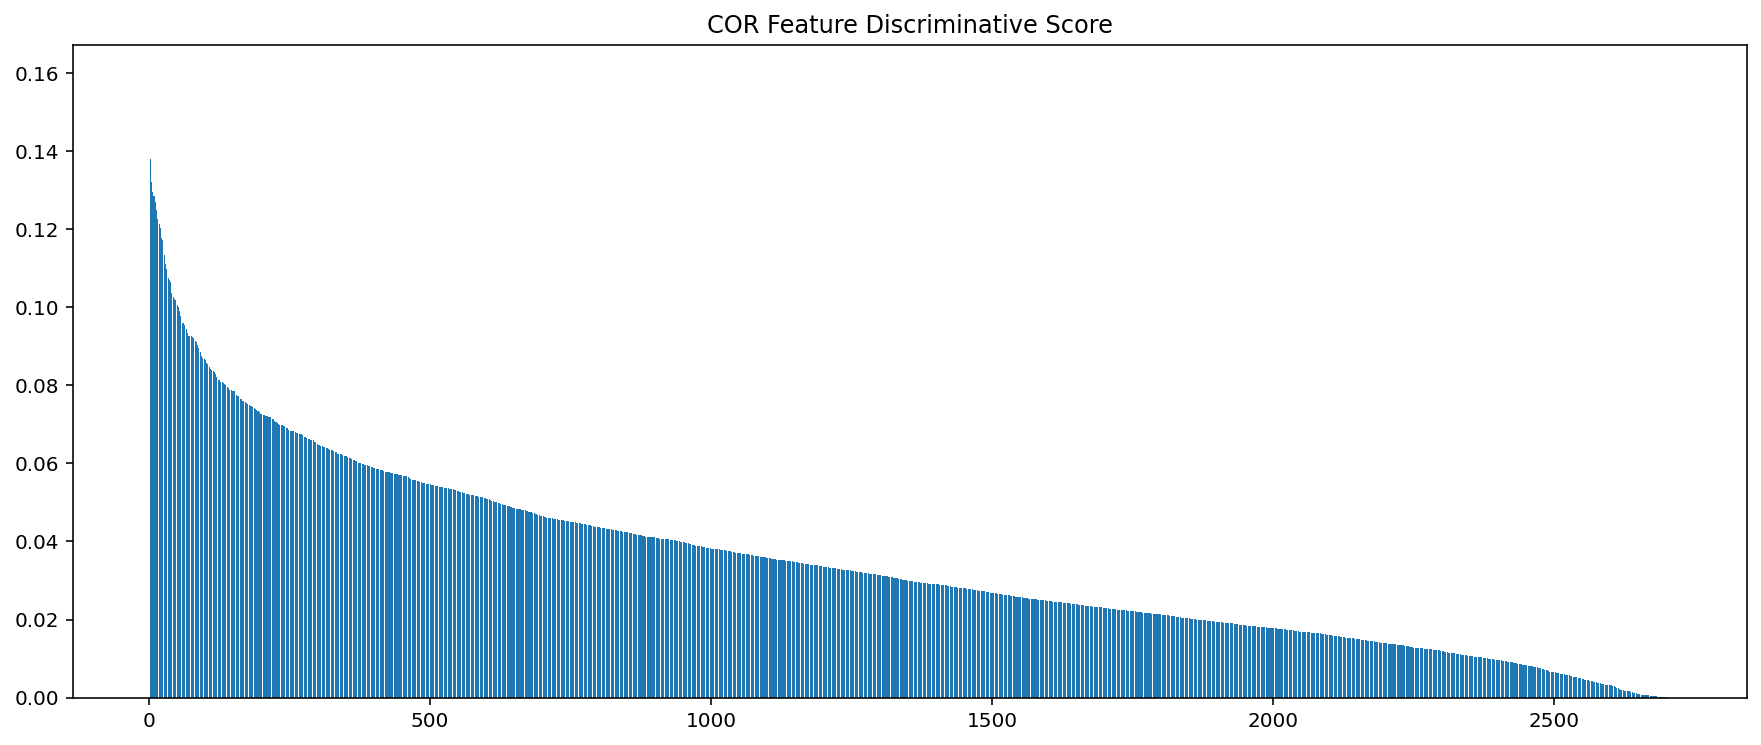

In [787]:
Sf = calc_COR()
cor_df = pd.DataFrame({'cor':Sf},
                      index=gene_flt.columns[1:]).sort_values(by='cor', ascending=False)
plt.figure(figsize=(15,6))
plt.bar(np.arange(2707)+1, cor_df['cor'])
plt.title('COR Feature Discriminative Score')
plt.show()

In [788]:
# #selected by coeff from RF model
# RF_f = feature_imp['feature'][:100]
# # selected by coeff from logistic reg
# Logit_f = logit_imp['feature'][:100]
# selected by feature discriminability)
COR_f = cor_df.index.tolist()[:200]

In [789]:
df_filtered = gene_flt.loc[:, COR_f]
df_filtered['group'] = gene['group']
# df_filtered.to_csv('Data/gene_filtered_200.csv')

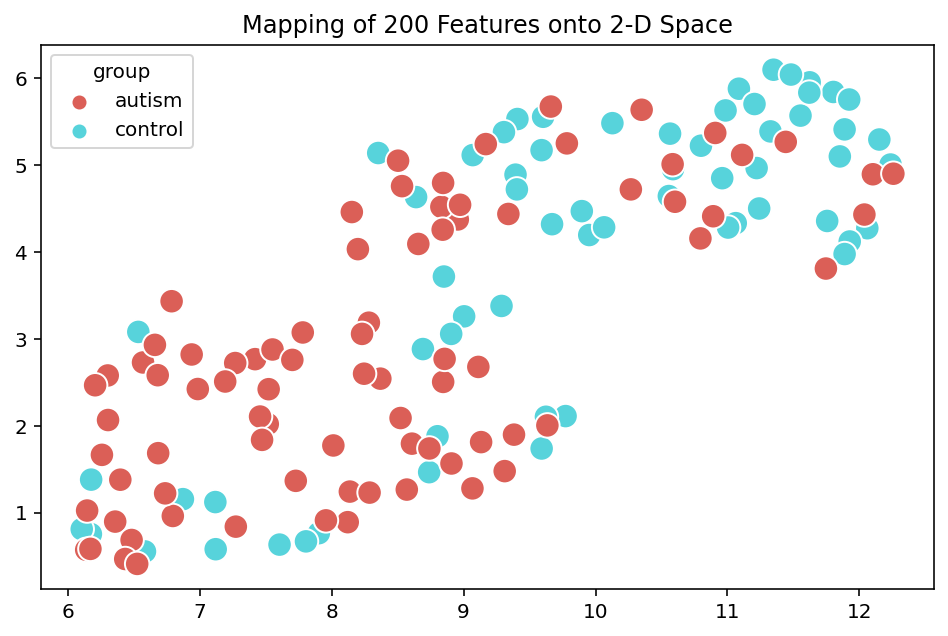

In [790]:
draw_umap(df_filtered.iloc[:,:-1])
plt.title("Mapping of 200 Features onto 2-D Space")
plt.show()

# Classification

## Logistic Regression 

In [ ]:
# Dataset
X = gene_flt.iloc[:,1:]
y = gene['group']

# logistic regression with L1 penalty
Cs = np.logspace(-5,5,20)
mdl = lm.LogisticRegressionCV(Cs=Cs,
                           cv=5, 
                           penalty='l1',
                           solver='saga', random_state=42).fit(X, y)

plt.semilogx(1/Cs, mdl.scores_['control'].mean(axis=0) )
plt.errorbar(1/Cs, mdl.scores_['control'].mean(axis=0),
             mdl.scores_['control'].std(axis=0)/np.sqrt(10) )
plt.xlabel('lambda (regularization strength)')
plt.ylabel('Score (Classification accuracy)')

In [767]:
xtrain, xtest, ytrain, ytest = train_test_split(x_10, y,test_size=0.2, shuffle=True)
logit=lm.LogisticRegression(C=C, 
                            solver='saga',
                            random_state=41).fit(xtrain, ytrain)

train_pred = logit.predict(xtrain)
train_acc = accuracy_score(ytrain, train_pred)
train_acc

0.7758620689655172

In [ ]:
C = Cs[np.argmax(mdl.scores_['control'].mean(axis=0))]
clf = lm.LogisticRegression(C=C, 
                            penalty='l1',
                            solver='saga',
                            random_state=42).fit(X, y)

# rank feature importance by coef from logistic model
# importances = np.abs(clf.coef_[0])
# feature_names = np.array(X.columns)
# logit_imp = pd.DataFrame({'feature':feature_names,'imp':importances})
# logit_imp.imp.describe()

# logit_imp = logit_imp.sort_values(by='imp', ascending=False)
# plt.figure(figsize=(10,4))
# plt.plot(np.arange(gene_flt.shape[1]-1), logit_imp['imp'])
# plt.xlabel('features')
# plt.ylabel('Coefficient')
# plt.xticks(rotation=45)
# plt.show()

# Random Forest

In [792]:
from scipy import interp

In [870]:
def my_RF_classifier(X, y, n_splits=10):
    train_aucs = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=40)
    for train, test in kf.split(X,y):
        clf = RandomForestClassifier(random_state=42).fit(X.iloc[train,:],
                                                          y.iloc[train])
        # training prediciton accuracy
        train_pred = clf.predict(X.iloc[train,:])
        train_auc = accuracy_score(train_pred, y.iloc[train])
        train_aucs.append(train_auc)
        
        # test set classification metrics
        test_pred = clf.predict(X.iloc[test,:])
        fpr, tpr, threshold = roc_curve(test_pred, y.iloc[test])
        tprs.append(interp(mean_fpr, fpr, tpr))
        aucs.append( auc(fpr, tpr) )
    
    return clf, train_aucs, tprs


def plot_roc(tprs, text,
             mean_fpr = np.linspace(0,1,100)):
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr,
             lw=2, alpha=1,
             label=r'%s features (AUC = %0.2f )' % (text, mean_auc))


## RF-Based Feature Selection

In [801]:
# replace y labels with binary {1, 0}
y = gene['group']
y.replace({'autism':1,'control':0}, inplace=True)

# RF with full features 
clf0, train_aucs0, tprs0 = my_RF_classifier(X=raw_data, y=y)

 Using feature importance from coefficients evaluated by RF Algorithm, selected `1018` out of all 50000+ features:

In [802]:
feature_names = [f"{i}" for i in gene.columns[1:]]
# feature importance with coeff
importances = clf0.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

feature_imp = pd.DataFrame({'feature':feature_names,'imp':importances})
feature_imp = feature_imp.sort_values(by='imp', ascending=False)

flted_features = list(feature_imp[feature_imp['imp']!=0]['feature'])
len(flted_features)

1018

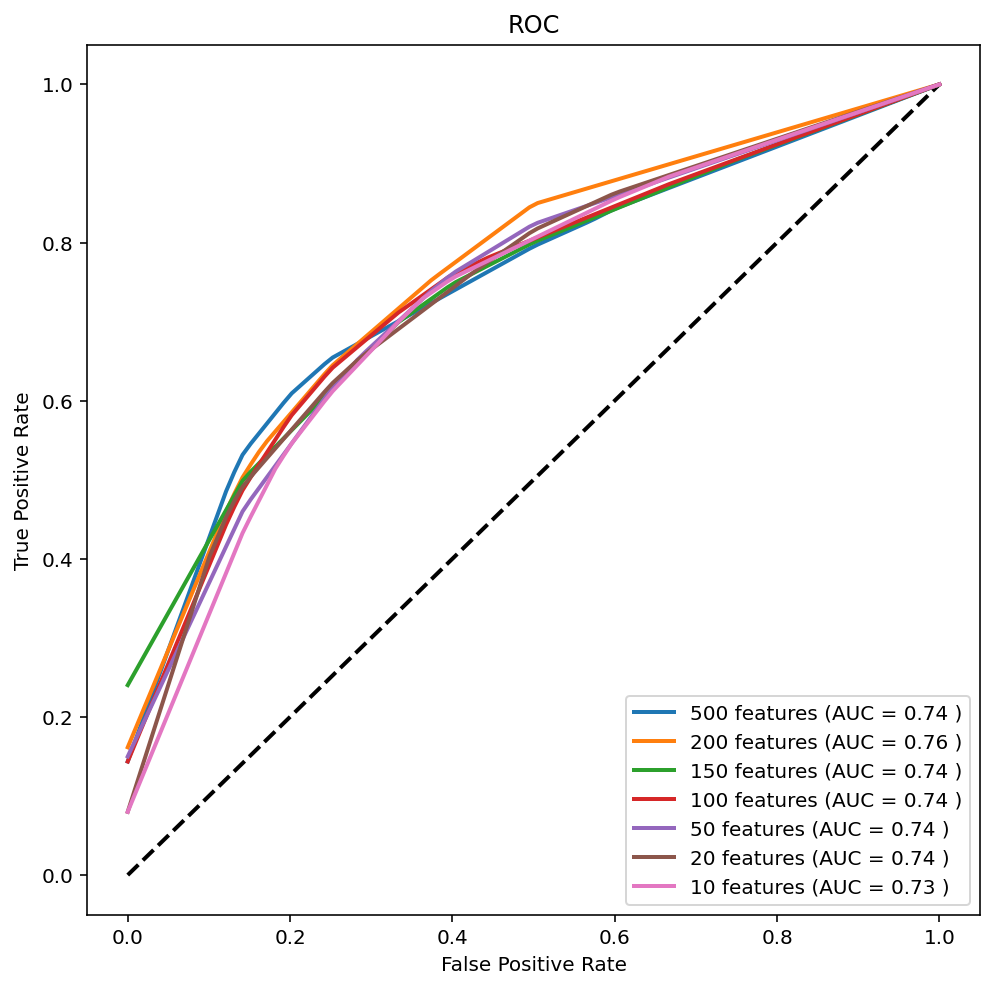

In [803]:
# Reselect n features from 1018 features with COR 
Sf = calc_COR(data=gene.loc[:,flted_features])
cor_df = pd.DataFrame({'cor':Sf}, 
                      index=flted_features).sort_values(by='cor',ascending=False)

fs_ls = []
ns =[500,200,150,100,50,20,10]
for n in ns:
    cor_f = cor_df.iloc[:n,].index.tolist()
    fs_ls.append(cor_f)

plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
for i in range(len(fs_ls)):
    X = gene.loc[:,fs_ls[i]]
    clf, tacc, tprs = my_RF_classifier(X, y)
    plot_roc(tprs, text='%d'%(ns[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [901]:
# 2707 features
clf1, train_aucs1, tprs1 = my_RF_classifier(X=gene_flt.iloc[:,1:], y=y)
# Previous 200 features
clf2, train_aucs2, tprs2 = my_RF_classifier(X=df_filtered.iloc[:,:-1], y=y)
# 10 features selected by mean-cor 
X10 = gene.loc[:,COR_f[:20]]
clf3, train_aucs3, tprs3 =  my_RF_classifier(X10, y)
# 200 features selected from above 1018 fs
X4 = gene.loc[:,fs_ls[1]] 
clf4, train_aucs4, tprs4 = my_RF_classifier(X4, y)

# 10 features selected from above..
X_10 = gene.loc[:,fs_ls[-1]]
clf5, train_acus5, tprs5 = my_RF_classifier(X_10, y)

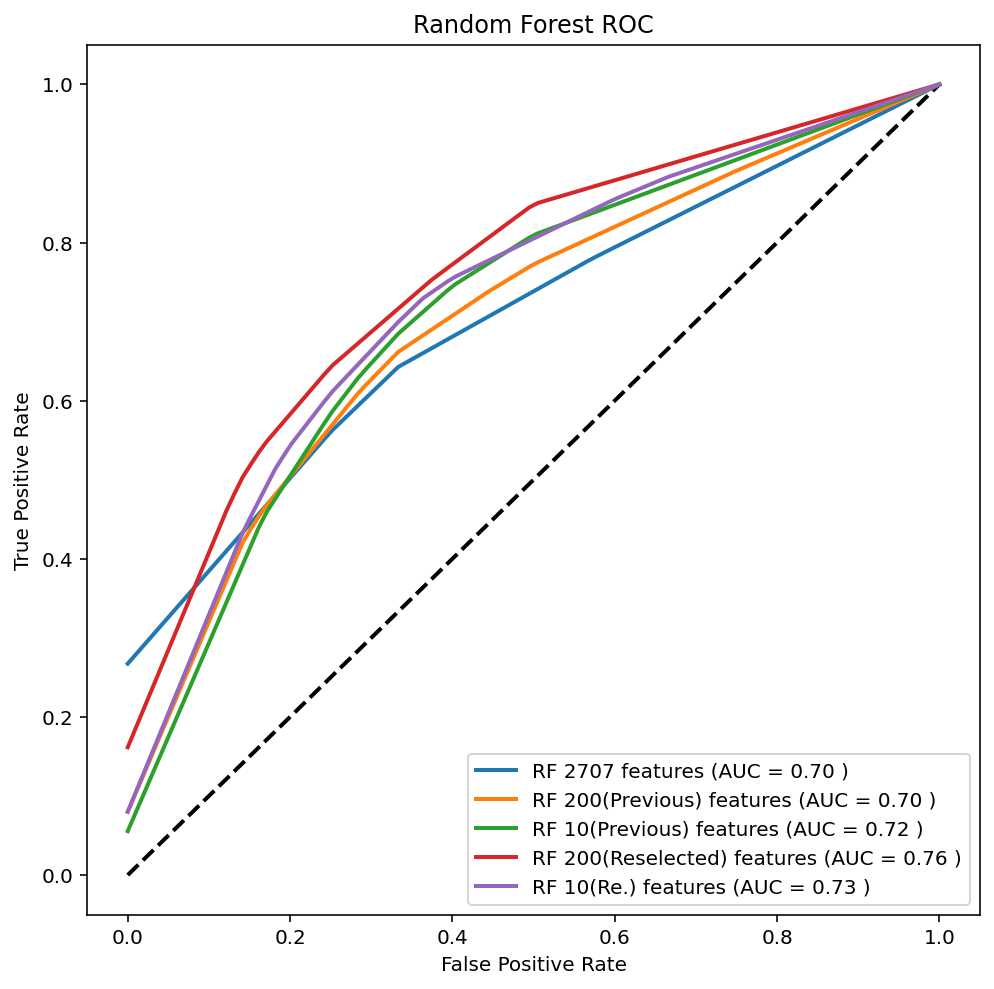

In [903]:
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
# plot_roc(tprs0, text='RF full')
plot_roc(tprs1, text='RF 2707')
plot_roc(tprs2, text='RF 200(Previous)')
plot_roc(tprs3, text='RF 10(Previous)')
plot_roc(tprs4, text='RF 200(Reselected)')
plot_roc(tprs5, text='RF 10(Re.)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

In [674]:
# x_100=gene.loc[:,fs_ls[-4]]
# x_100['group']=gene['group']
# x_100
# x_100.to_csv('Data/gene_100_features.csv')

In [470]:
gene_bestf = X4
gene_bestf['group'] = gene['group']
# gene_bestf.to_csv('Data/gene_best_200.csv')

## Support Vector Machine

In [852]:
from sklearn.svm import SVC

In [886]:
def my_SVM_CV(X, y, kernal='rbf', n_splits=10): # for k-fold cross-validation):
    train_aucs, aucs, tprs = [],[],[]
    mean_fpr = np.linspace(0,1,100)   
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train, test in kf.split(X, y):
        # obtain classifier
        clf = SVC(kernel=kernal, random_state=42).fit(X.iloc[train,:],
                                                      y.iloc[train])
        # train 
        # train_pred = clf.decision_function(X.iloc[train,:])
        train_pred = clf.predict(X.iloc[train,:])
        train_auc = accuracy_score(y.iloc[train], train_pred)
        train_aucs.append(train_auc)
        
        # test 
        # test_pred = clf.decision_function(X.iloc[test,:]) 
        test_pred = clf.predict(X.iloc[test,:])
        fpr, tpr, t = roc_curve(y.iloc[test], test_pred)
        tprs.append(interp(mean_fpr, fpr, tpr))
        aucs.append( auc(fpr, tpr) )
        
    return clf, train_aucs, tprs

In [892]:
# # Fit SVM model with 2707 features
X1 = gene_flt.iloc[:,1:]
svm0, tauc0, svm_tprs0 = my_SVM_CV(X1, y)
# 200 (previous) features
svm1, tauc1, svm_tprs1 = my_SVM_CV(df_filtered.iloc[:,:-1], y)
# 10 (previous) features
svm5, tauc5, svm_tprs5 = my_SVM_CV(X10, y)
# 200 features
svm2, tauc2, svm_tprs2 = my_SVM_CV(X4, y)
# 20 features
X_20 = gene.loc[:,fs_ls[-2]]
svm3, tauc3, svm_tprs3 = my_SVM_CV(X_20, y)
# 10 features
svm4, tauc4, svm_tprs4 = my_SVM_CV(X_10, y)

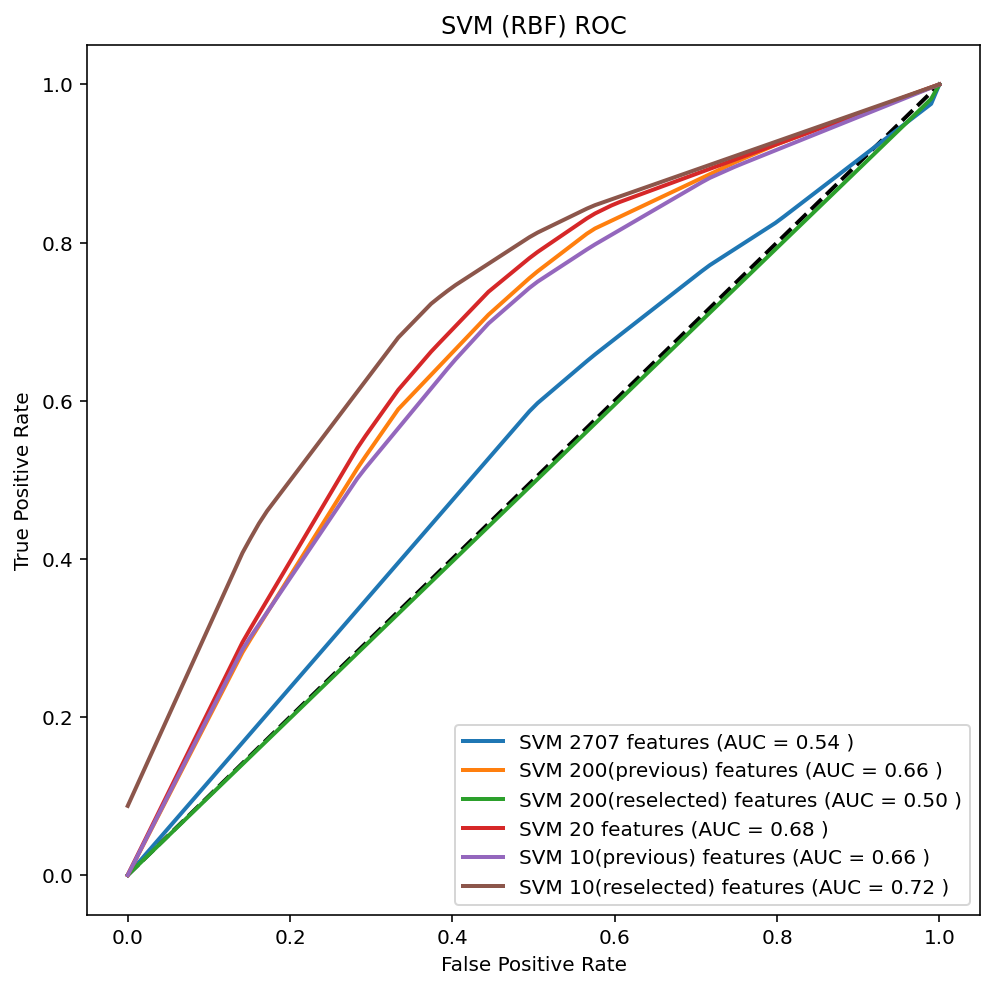

In [905]:
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')

plot_roc(svm_tprs0, text='SVM 2707')
plot_roc(svm_tprs1, text='SVM 200(previous)')
plot_roc(svm_tprs2, text='SVM 200(reselected)')
plot_roc(svm_tprs3, text='SVM 20')
plot_roc(svm_tprs5, text='SVM 10(previous)')
plot_roc(svm_tprs4, text='SVM 10(reselected)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM (RBF) ROC')
plt.legend(loc="lower right")
plt.show()

In [896]:
## Linear
# 200 (previous) features
svml1, tauc1, svml_tprs1 = my_SVM_CV(df_filtered.iloc[:,:-1], y,
                                  kernal='linear')
# 200 features
svml2, tauc2, svml_tprs2 = my_SVM_CV(X4, y, kernal='linear')
# 20 features
X_20 = gene.loc[:,fs_ls[-2]]
svml3, tauc3, svml_tprs3 = my_SVM_CV(X_20, y, kernal='linear')
# 10 features
svml4, tauc4, svml_tprs4 = my_SVM_CV(X_10, y, kernal='linear')


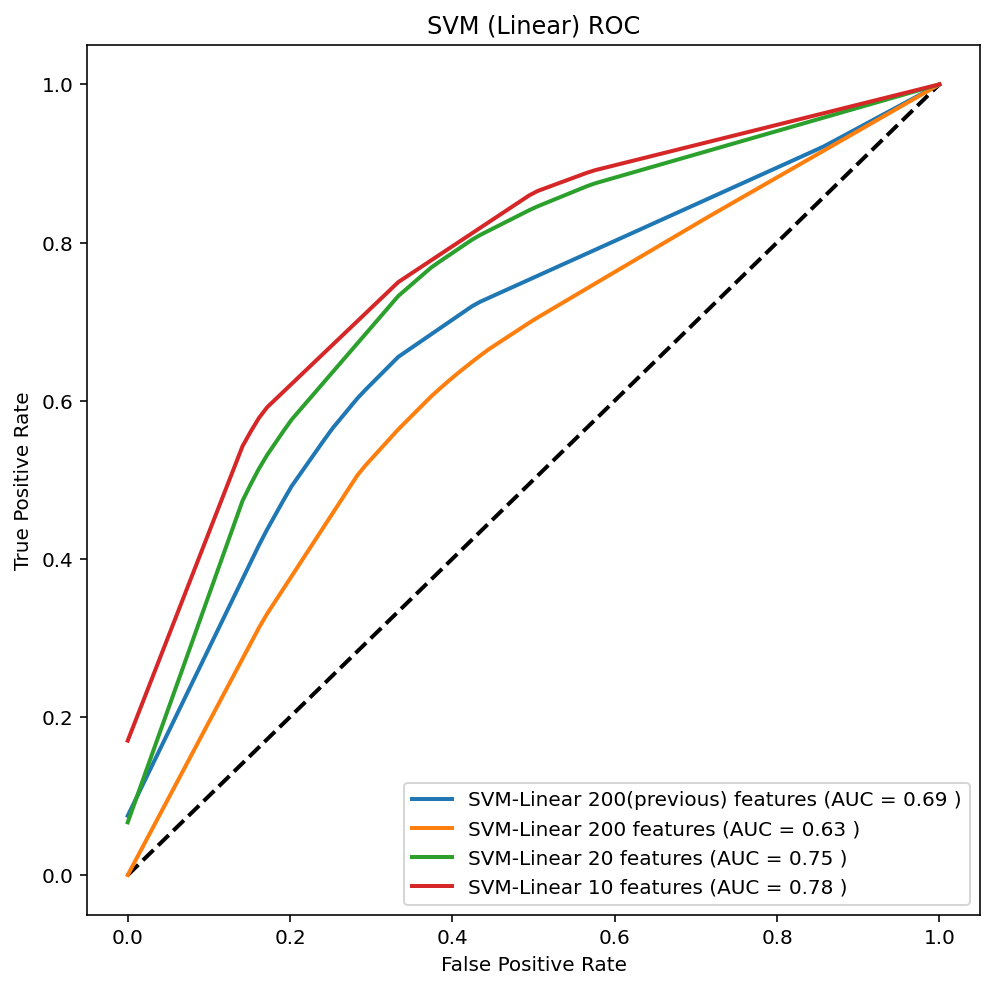

In [897]:
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')

# plot_roc(tprs1, text='RF 2707')
# plot_roc(svm_tprs0, text='SVM 2707')
plot_roc(svml_tprs1, text='SVM-Linear 200(previous)')
plot_roc(svml_tprs2, text='SVM-Linear 200')
plot_roc(svml_tprs3, text='SVM-Linear 20')
plot_roc(svml_tprs4, text='SVM-Linear 10')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM (Linear) ROC')
plt.legend(loc="lower right")
plt.show()

 ##  可以最后整理一个roc图，呈现best performing models的结果

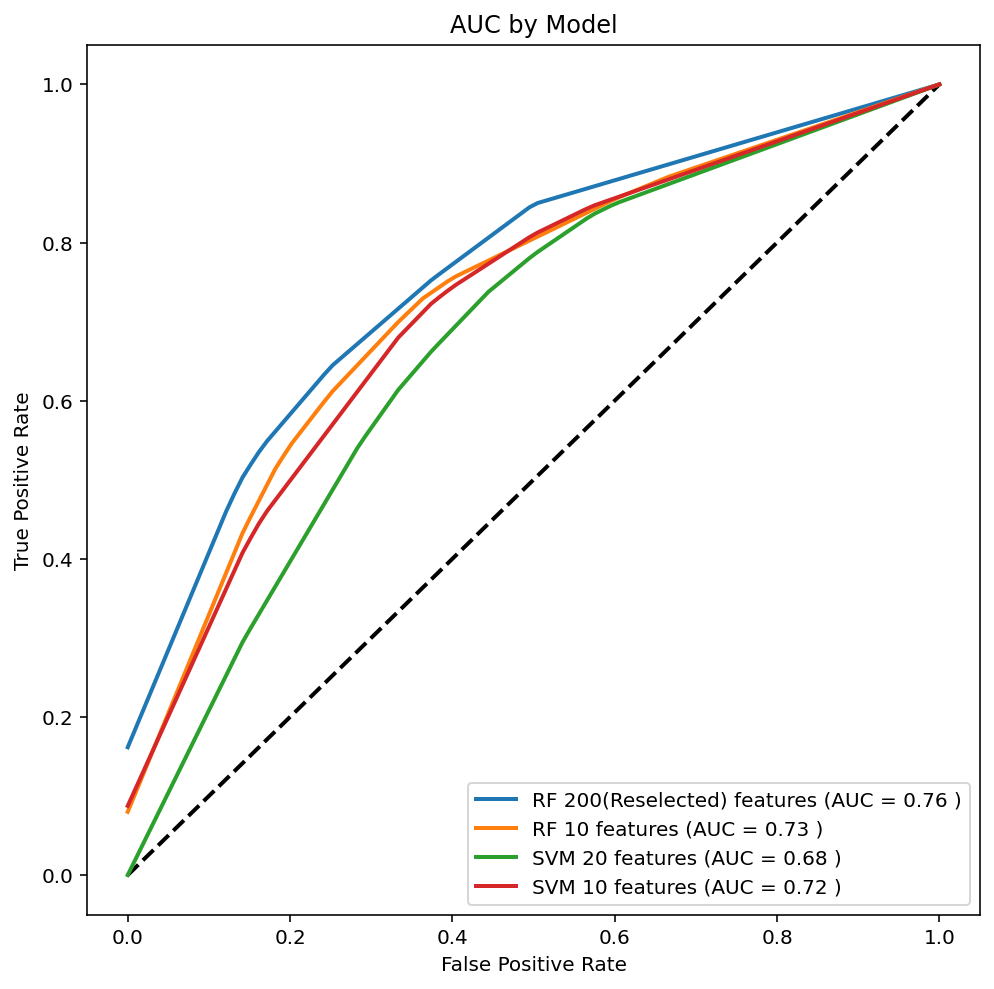

In [863]:
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plot_roc(tprs4, text='RF 200(Reselected)')
plot_roc(tprs3, text='RF 10')
plot_roc(svm_tprs3, text='SVM 20')
plot_roc(svm_tprs4, text='SVM 10')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC by Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
draw_umap(X4)
plt.title('200-feature mapping')
draw_umap(X_10)
plt.title('10-feature mapping')